# <center> Solar Panel Detection using Deep Learning

---

**CSE4006 - Deep Learning**      

**Project Name: Solar Panel Detection using Deep Learning**

---

<center> <img src = "https://miro.medium.com/max/1400/1*QJEnWss0ENhft6hmpuYU0A.webp" width = 55%>


## Workflow of this notebook
**1)** [Introducing the Problem](#h1)      
**2)** [Understanding the Dataset](#h2)    
**3)** [Importing necessary libraries and modules for this notebook](#h3)      
**4)** [Exploratory Analysis & Data Scaling](#h4)           
**5)** [Building & Tuning our CNN Model](#h5)   
**6)** [Model Evaluation & Results](#h6)        


#Introduction to the problem <a name ="h1"></a>

###Why should solar panels be detected?

###Problem Statement:

<p align="justify">
Southern African countries, including Zimbabwe, are facing severe electricity shortages due to power generation issues and an over-reliance on non-renewable sources. As a result, many households and businesses are turning to solar energy to meet their power needs. However, the lack of detailed information on where solar panels are installed and how much power they generate is a major obstacle for energy planners, solar suppliers, and policy makers trying to address the energy crisis.

An imagery-based solar panel detection algorithm, using satellite or aerial images, could create a database of solar panel installations across the country. This database would provide valuable information on the spread and capacity of solar energy systems. Such data is critical for:


*   Helping energy companies understand the growing solar market
*   Assisting governments in energy planning and creating policies to promote renewable energy
*   Enabling better grid management by tracking off-grid and on-grid solar installations


In Zimbabwe, where solar energy is increasingly becoming the primary power source for many, the need for an automated system to detect and map solar panel installations is crucial. However, little effort has been made to develop such technology in the region.

To build this solution, the first step is to gather a labeled dataset of satellite images showing solar panels. This will enable the development of an algorithm that can accurately detect solar panels from aerial or satellite images.

# Understanding the Dataset<a name ="h2"></a>

##### <center> <b>Here are a few snippets from the dataset - Images containing Solar Panels </b>

<center> <img src = "https://anna-berman.com/images/solarPV-PV.png" width = 75%>

##### <center> <b>Here are a few snippets from the dataset - Images NOT containing Solar Panels</b>
<center> <img src = "https://anna-berman.com/images/solarPV-PVno.png" width = 75%>


<p align="justify">When examining the photographs themselves, it is clear that solar panels frequently have rectangular shapes with distinct angles and borders. However, the whole pictures that include solar PV do not necessarily have a same structure. The solar panels are not always at the centre of images, which come in a range of sizes and hues. Additionally, the background scenery in the photographs of the two classes is also not uniform. Both classes contain illustrations of home swimming pools, pavement, grass, and rooftops. A model should also be able to predict the same class independent of the orientation of each image.

#Importing necessary libraries and modules for this notebook<a name ="h3"></a>

In [ ]:
# importing all necessary libraries

# data handling & linear algebra
import numpy as np
import pandas as pd

# visualisation
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import rcParams
import seaborn as sns

# data analysis
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

# manipulating data and model building
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import GlobalMaxPooling2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Add
from keras.models import Sequential

###Importing Google Drive for Dataset Access

- Download <a href="https://drive.google.com/drive/folders/1Pe887pD6DP0nsqq0G1BdoMNExDvBoSp9?usp=sharing" target="_blank">this dataset</a> to your system.
- Upload this 'data' folder directly in your 'Main Drive'.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# define dataset directories - the below links won't work if you haven't placed 'data' folder in your 'Main Drive'
DIR_TRAIN_IMAGES = "/content/drive/My Drive/PROJECTS/SOLAR PANEL DETECTION SYSTEM/dataset/training"
DIR_TRAIN_LABELS = "/content/drive/My Drive/PROJECTS/SOLAR PANEL DETECTION SYSTEM/dataset/labels_training.csv"

#Exploratory Analysis & Data Scaling<a name ="h4"></a>




In [ ]:
pd.read_csv(DIR_TRAIN_LABELS).head()

- id are names of the image before tif
- label has two values:
  - 0: No solar panels in the image
  - 1: Solar panels present in the image

In [ ]:
# LOADING DATA AND PREPROCESSING

def load_data(dir_data, dir_labels):
    '''
    dir_data: Data directory
    dir_labels: Respective csv file containing ids and labels
    returns: Array of all the image arrays and its respective labels
    '''
    labels_pd = pd.read_csv(dir_labels)                         # Read the csv file with labels and ids as we saw above
    ids = labels_pd.id.values                                   # Extracting ids from the csv file
    data = []                                                   # Initiating the empty list to store each image as numpy array
    for identifier in ids:                                      # Looping into the desired folder
        fname = dir_data + identifier.astype(str) + '.tif'      # Generating the file name
        image = mpl.image.imread(fname)                         # Reading image as numpy array using matplotlib
        data.append(image)                                      # Appending this array into the empty list and repeat the above cycle
    data = np.array(data)                                       # Now, convert the data list into data array
    labels = labels_pd.label.values                             # Extract labels from the csv file
    return data, labels                                         # Return the array of data and respective labels

In [ ]:
# load train data - time consuming code cell
X, y = load_data(DIR_TRAIN_IMAGES, DIR_TRAIN_LABELS)

In [ ]:
# display the images with and without solar panels
plt.figure(figsize = (13,8))                         # Adjust the figure size
for i in range(6):                                   # For first 6 images in the data
  plt.subplot(2, 3, i+1)                             # Create subplots
  plt.imshow(X[i])                                   # Show the respective image in respective postion
  if y[i] == 0:                                      # If label is 0
    title = 'No Solar Panels in this image'          # Set this as the title
  else:                                              # Else label is 1
    title = 'Solar Panels in this image'             # Set this as the title
  plt.title(title, color = 'r', weight = 'bold')     # Adding title to each images in the subplot
plt.tight_layout()                                   # Automatically adjusts the width and height between images in subplot
plt.show()                                           # Display the subplot

In [ ]:
# print data shape
print('X shape:\n', X.shape)

- 1500 total images in the training data
- Each image is of shape (101 x 101 x 3)

In [ ]:
# check number of samples
print('Distribution of y', np.bincount(y))

- Out of 1500 images:
  - 995 images are without any solar panels
  - 505 images are with solar panels

In [ ]:
# scale pixel values between 0 and 1
X = X / 255.0

#Building the CNN Model<a name ="h5"></a>

<p align="justify">A neural network type with a topology resembling a grid is known as a CNN. The effectiveness of CNNs in computer vision applications including image classification, picture clustering, and object identification is well recognised. Convolutional neural networks (CNNs) at least one of its layers instead of matrix multiplication at their core. They are structured like other neural networks by a series of layers. Neurons are grouped in three dimensions—width, height, and depth—in the layers of CNN. Although there are many various kinds of CNN architectures, they are the best option for picture identification since they handle pixels in relation to their surrounds.

<center> <img src = "https://miro.medium.com/max/1400/1*kkyW7BR5FZJq4_oBTx3OPQ.webp" width = 85%>

The convolutional layer applies a convolution operation, the output is passed to the next layer. The pool layer performs a down sampling operation by combining the outputs of neurons at one layer into a single neuron in the next layer. The flatten reshapes the feature map into a column. The full-connection layer will compute the class scores, each neuron in this layer will be connected to all the neurons in the previous one

*Credits* - [MathWorks](https://www.mathworks.com/videos/introduction-to-deep-learning-what-are-convolutional-neural-networks--1489512765771.html)

In [ ]:
# MODEL : CONVOLUTIONAL NEURAL NETWORK

# define CNN
def build_model():
    '''
    Returns a Keras CNN model
    '''

    # define image dimensions
    IMAGE_HEIGHT = 101
    IMAGE_WIDTH = 101
    IMAGE_CHANNELS = 3

    # define a straightforward sequential neural network
    model = Sequential()

    # layer-1
    # filter is convolutional matrix which is applied across the image = 32 filters
    # kernal size is 3x3 matrix(filter)
    # relu positive kept as it is, negative is taken out
    model.add(Conv2D(filters=32,
                     kernel_size=3,
                     activation='relu',
                     input_shape=(IMAGE_HEIGHT,
                                  IMAGE_WIDTH,
                                  IMAGE_CHANNELS)))

    # adding normalizing layer to improve the speed of training
    model.add(BatchNormalization())

    # As we move forword in the layers pattern gets more complex,
    # to capture the maximum combinations in subsequent layers
    # layer-2
    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # layer-3
    model.add(Conv2D(filters=128,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # Pooling layer is to reduce dimentions of feature map by summerizing presence of features
    # max-pool - sends only imp data to next layer - here 2x2 matrix
    model.add(MaxPooling2D(pool_size=2))

    # layer-4
    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # layer-5
    model.add(Conv2D(filters=128,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # max-pool
    model.add(MaxPooling2D(pool_size=2))

    # layer-6
    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # layer-7
    model.add(Conv2D(filters=128,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())

    # gobal-max-pool- performs downsampling by computing the maximum of the height and width dimensions of the input
    # using it as a substitute of Flatten before passing it to the final layer
    model.add(GlobalMaxPooling2D())

    # output layer
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


##Checking the Performance of our CNN Model

In [ ]:
# cross-validate CNN model
def cv_performance_assessment(X, y, num_folds, clf, random_seed=1):
    '''
    Cross validated performance assessment

    Input:
        X: training data
        y: training labels
        num_folds: number of folds for cross validation
        clf: classifier to use

    Divide the training data into k folds of training and validation data.
    For each fold the classifier will be trained on the training data and
    tested on the validation data. The classifier prediction scores are
    aggregated and output.
    '''

    prediction_scores = np.empty(y.shape[0], dtype='object')

    # establish the num_folds folds
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_seed)

    for train_index, val_index in kf.split(X, y):
        # extract the training and validation data for this fold
        X_train, X_val = X[train_index], X[val_index]
        y_train = y[train_index]

        # give more weight to minority class based on the target class distribution
        class_weight = {0: 505/1500, 1: 995/1500}

        # train the classifier
        training = clf.fit(x=X_train,
                           y=y_train,
                           class_weight=class_weight,
                           batch_size=32,
                           epochs=10,
                           shuffle=True,
                           verbose=1)

        # test the classifier on the validation data for this fold
        y_val_pred_probs = clf.predict(X_val).reshape((-1, ))

        # save the predictions for this fold
        prediction_scores[val_index] = y_val_pred_probs

    return prediction_scores

In [ ]:
# number of subsets of data, where k subsets are used as test set and other k-1 subsets are used for the training purpose
num_folds = 3

# seed value is the previous value number generated by the random function
random_seed = 1

# build_model() function returns the predefined sequential model
cnn = build_model()

# lets look at summary of the model
cnn.summary()

# generate the probabilities (y_pred_prob)
cnn_y_hat_prob = cv_performance_assessment(X, y, num_folds, cnn, random_seed=random_seed)

Looking at the True Positives, False Negatives, False Positives & True Negatives -



In [ ]:
df = pd.read_csv(DIR_TRAIN_LABELS)                                              # Create a data frame of labels
df["predicted_class"] = [1 if pred >= 0.5 else 0 for pred in cnn_y_hat_prob]    # Add a column to it for predicted class

# Get the values for FN, FP, TP, TN
fn = np.array(df[(df['label'] == 1) & (df['predicted_score'] == 0)]['id'])      # False Negative
fp = np.array(df[(df['label'] == 0) & (df['predicted_score'] == 1)]['id'])      # False Positive
tp = np.array(df[(df['label'] == 1) & (df['predicted_score'] == 1)]['id'])      # True Positive
tn = np.array(df[(df['label'] == 0) & (df['predicted_score'] == 0)]['id'])      # True Negative

In [ ]:
# Visuals of TP, TN, FP, and FN
def show_images(image_ids, num_images, title, color):
    '''
    Display a subset of images from the image_ids data
    '''
    rcParams['figure.figsize'] = 20, 4                                          # Adjusting figure size
    plt.figure()                                                                # Generating figure
    n = 1                                                                       # index where plot should apear in subplot
    for i in image_ids[0:num_images]:                                           # Run a loop for total number of images to display
        plt.subplot(1, num_images, n)                                           # Generate a subplot
        plt.imshow(X[i, :, :, :])                                               # Display the image
        plt.title('Image id: ' + str(i))                                        # Add title
        plt.axis('off')                                                         # Turn off the axis
        n+=1                                                                    # Incrememting index by 1
    plt.suptitle('\n'+title, fontsize=15, color = color, weight = 'bold')       # Adding main title to subplot
    plt.show()                                                                  # Display the final output

In [ ]:
num_images = 7  # number of images to look at
show_images(tp, num_images, 'Examples of True Positives - Predicted solar panels if they were present', 'g')
show_images(fp, num_images, 'Examples of False Positives - Predicted solar panels even if they were not present', 'r')
show_images(tn, num_images, 'Examples of True Negatives - Predicted no solar panels when they were not present', 'g')
show_images(fn, num_images, 'Examples of False Negatives - Predicted no solar panels even if they were present', 'r')

# Model Evaluation & Results<a name ="h6"></a>

## Understanding ROC Curves -

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

*   True Positive Rate
*   False Positive Rate

<center>True Positive Rate (TPR) is a synonym for recall and is therefore defined as follows:

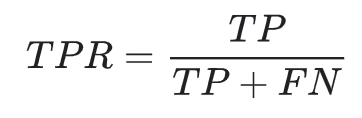

False Positive Rate (FPR) is defined as follows:

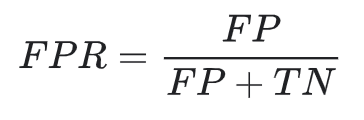

An ROC curve plots TPR vs. FPR at different classification thresholds.

Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives.</center>

####AUC: Area Under the ROC Curve -
AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve from 0 to 1.
AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the **probability that the model ranks a random positive example more highly than a random negative example**. AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

In [ ]:
# ROC - AUC
def plot_roc(y_true, y_pred_cnn):
    '''
    Plots ROC curves for the CNN models.
    '''
    plt.figure(figsize=(8, 8))

    # ROC of CNN
    fpr, tpr, _ = roc_curve(y_true, y_pred_cnn, pos_label=1)
    auc = roc_auc_score(y_true, y_pred_cnn)
    legend_string = 'CNN Model - AUC = {:0.3f}'.format(auc)
    plt.plot(fpr, tpr, color='red', label=legend_string)

    # ROC of chance
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Chance - AUC = 0.5')

    # plot aesthetics
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.tight_layout()
    plt.title('ROC Curve', fontsize=10)
    pass

In [ ]:
# plot ROC
y_pred = [1 if pred >= 0.5 else 0 for pred in cnn_y_hat_prob]
plot_roc(y,  cnn_y_hat_prob)
plot_roc(y, y_pred)

**CONFUSION MATRIX**         
<img src = 'https://miro.medium.com/max/1218/1*jMs1RmSwnYgR9CsBw-z1dw.png'>

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y, y_pred), annot = True, cbar = False, fmt='.0f')
plt.show()